# JOHNSTON - 67-Markers Data Set v.7a

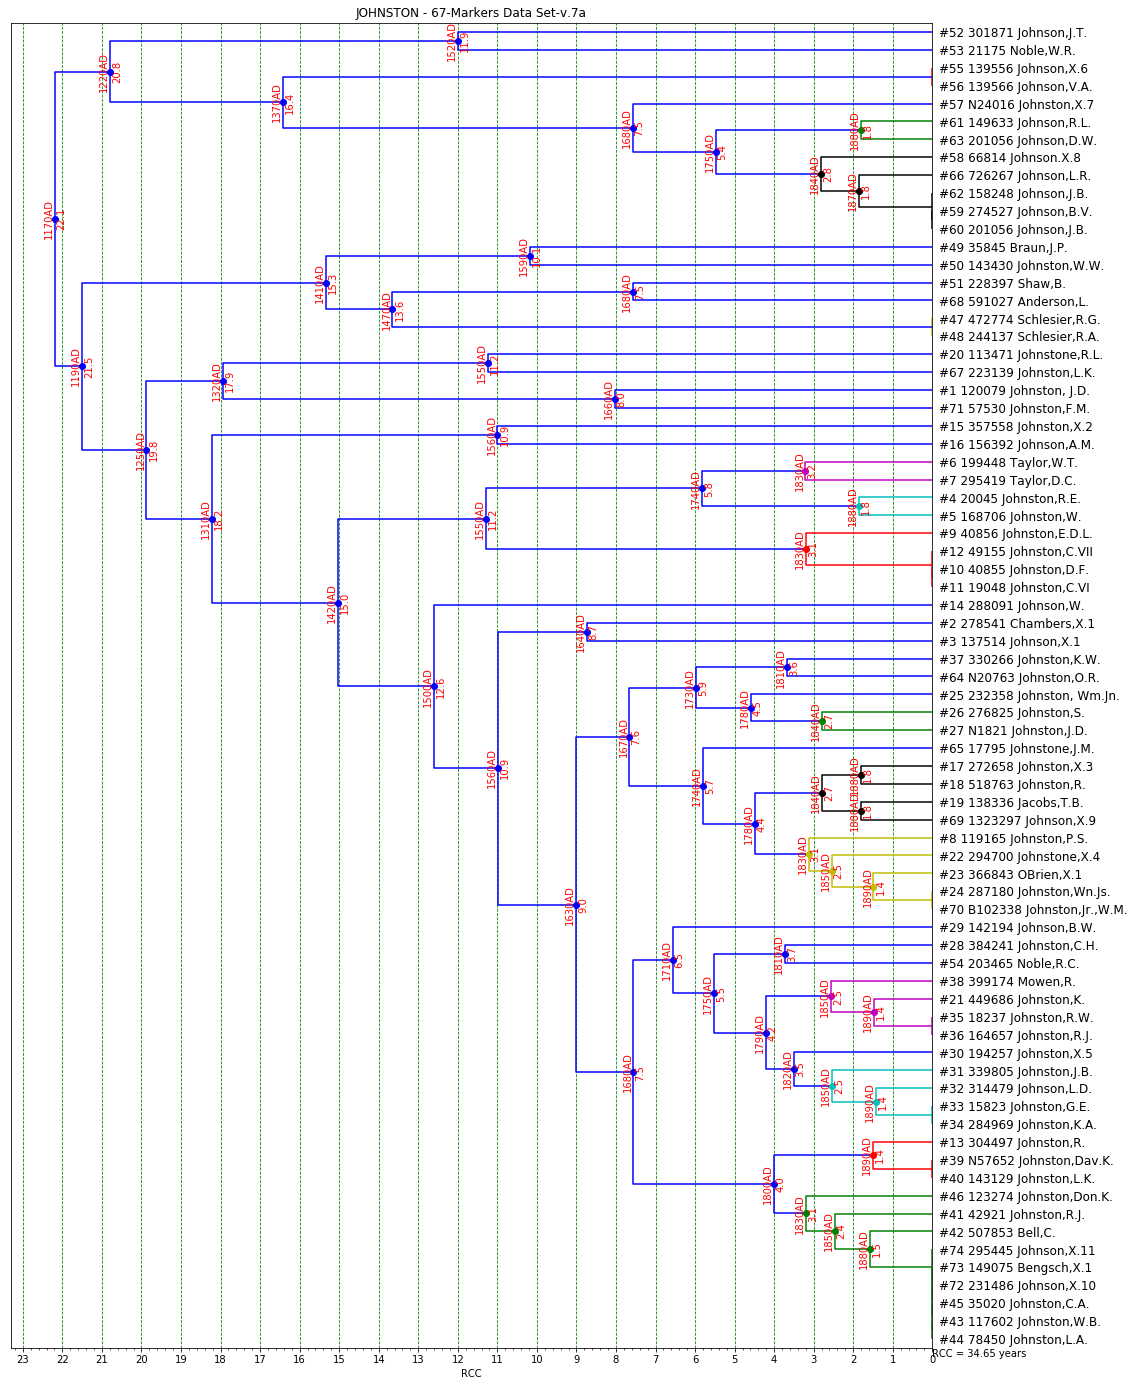

In [1]:
# Copyright (C) 2018 David Johnston. All rights reserved.
# Notebook to produce a Phylogenetic tree (dendrogram) of the Johnston Y-DNA kit results
# Based on the work done by Bill Howard and Fred Schwab

%matplotlib inline
from scipy.cluster.hierarchy import dendrogram , linkage
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt
import math

I = 'JOHNSTON - 67-Markers Data Set-v.7a'
Rscale = 34.65

# read the PDF 
C = pd.read_csv("{input}.csv".format(input=I)).values

# extract the kits as rows of observations and columns of attributes (markers)
K = C[:,2:69]

# extract the kit numbers and names to produce a labels matrix
L = []
for ix,row in enumerate(C):
    L.append("#{ix} {kit} {name}".format(ix=ix+1,kit=row[0],name=row[1]))
    
# calculate a condensed distance matrix consisting of RCC values as per Bill Howards paper
# the condensed distance matrix is a single dimension matrix containing 
# the top triangle of a two dimensional distance matrix
# e.g. [1,2,3,4]
#      [2,1,2,3]
#      [3,2,1,2]
#      [4,3,2,1]
# becomes a condensed distance matrix Y of [2,3,4,2,3,2]
Y = []
X = []
for i1,v1 in enumerate(K):
    X1 = []
    for i2,v2 in enumerate(K):
        if i2 > i1:
            Y.append((1/pearsonr(v1,v2)[0]-1)*10000.0)
        X1.append((1/pearsonr(v1,v2)[0]-1)*10000.0)
    X.append(X1)

# perform the agglomerative clustering using the average method as per Bill Howards paper
Z = linkage(Y,method='weighted',optimal_ordering=False)

# perform linkage reordering such that the shorter branch is first, the longer branch second
# the lower index is first, the higher index is second
for link in Z:
    leftDepth = link[0]
    if leftDepth >= len(L):
        leftDepth = Z[int(leftDepth)-len(L),3]
    else:
        leftDepth = 1
    rightDepth = link[1]
    if rightDepth >= len(L):
        rightDepth = Z[int(rightDepth)-len(L),3]
    else:
        rightDepth = 1
    if leftDepth < rightDepth:
        t = link[0]
        link[0] = link[1]
        link[1] = t
    elif link[0] < link[1] and link[0] < len(L) and link[1] < len(L):
            t = link[0]
            link[0] = link[1]
            link[1] = t

# plot the cluster hierarchy produced by linkage as a dendrogram
F = plt.figure(figsize=(16,20),dpi=72) # A1 paper
plt.title(I)
plt.xlabel("RCC")
plt.grid(True,which='major',axis='x',color='g',linestyle='dashed')
plt.minorticks_on()
plt.tick_params(axis='x',which='minor')
plt.tick_params(axis='y',which='minor',length=0)
plt.xticks(np.arange(24))
D = dendrogram(Z,labels=L,color_threshold=3.5,leaf_font_size=12,leaf_rotation=0,orientation='left')
for i, d, c in zip(D['icoord'], D['dcoord'], D['color_list']):
        y = 0.5 * sum(i[1:3])
        x = d[1]
        if x > 0:
            plt.plot(x, y, 'o', c=c)
            yr = math.floor((1943 - int(x* Rscale))/10)*10
            if yr >= 0:
                yr_txt = "{yr}AD".format(yr=yr)
            else:
                yr_txt = "{yr}BC".format(yr=-yr)
            rcc_txt = int(x*10)/10
            plt.annotate("%s" % yr_txt, (x, y), xytext=(-6, 0),
                             textcoords='offset points', color='r',
                             va='center', ha='center', rotation=90)
            plt.annotate("%s" % rcc_txt, (x, y), xytext=(+7, 0),
                             textcoords='offset points', color='r',
                             va='center', ha='center', rotation=90)
plt.annotate("RCC = {rscale} years".format(rscale=Rscale),(0,0),xytext=(0,-5))
F.subplots_adjust(left=0.05, right=0.85, top=0.97, bottom=0.05)
plt.savefig("{input}.jupyter.png".format(input=I))

# cite: http://www.jogg.info/pages/72/files/Howard.htm
# Dating Y-DNA Haplotypes on a Phylogenetic Tree: Tying the Genealogy of Pedigrees and Surname Clusters into Genetic Time Scales
# William E. Howard III and Frederic R. Schwab
